The hackathon data analysis is a summary of the EDA activities you have completed.  This should include data cleaning, pre-processing, exploratory analysis, and insights you have generated from your data. Each group will submit and demonstrate one notebook (in ipynb and pdf) that comprises the following sections:
### 1.Domain: Explain the domain/subdomain of this project (use images)
### 2.Data: Go over 1 row of the data explaining relevant columns
### 3.Insights: Show intuitive and non-intuitive insights generated from your EDA
### 4.Expected Objective: Sample input and output
___

# Domain

## Cloud Computing

**Cloud Computing (NIST)**:  a model for enabling on-demand network access to a shared 
pool of computing resources (e.g., networks, servers, storage, applications, 
and services) that can be rapidly provisioned and released with minimal management 
effort or service provider interaction.  

> <img src="images/CLOUD SETUP.png" width="500" height="500">

**5 Key Characteristics of Cloud Computing**

> 1. Broad Network Access
> 2. Measured Service
> 3. On Demand Self Service
> 4. Shared Resource Pooling
> 5. Rapid Elasticity

**3 Service Models**

> 1. **Software as a Service (SaaS)**: Provider’s applications running on a cloud infrastructure

> 2. **Platform as a Service (PaaS)**: Consumer-created or acquired applications created using tools supported by the provider

> 3. **Infrastructure as a Service (IaaS)**: Consumer is able to deploy and run arbitrary software on storage, networks, etc.

## Leading Cloud Service Providers

1. **Amazon Web Services (AWS)**
> <img src="images/AWS.png" width="150" height="150">

2. **Microsoft Azure**
> <img src="images/AZURE.png" width="150" height="150">

3. Google Cloud Platform
> <img src="images/GCP.png" width="200" height="200">

**Cloud Migration**: the process of moving a company’s digital assets, services, databases, IT resources, and applications either partially, or wholly, into the cloud. 

## Cloud Management

> <img src="images/CLOUD MANAGEMENT.png" width="800" height="800">

**MultiCloudX**: Austin based start-up that functions as a third-party cloud manager to manage cloud storage, operations, and costs

> <img src="images/MCX.png" width="300" height="500">

# Data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
dfCCO = pd.read_csv(r".\Data\cco_cost_monthly.csv")

In [4]:
dfPYCO = pd.read_csv(r".\Data\pyco_cost_monthly.csv", low_memory=False)

In [5]:
dfXCO = pd.read_csv(r".\Data\xco_cost_monthly.csv")

In [6]:
dfCCO.head()

,cloud_resource_id,usage_account_id,billing_account_id,provider_code,usage_amount,currency_code,tax,sub_total,total_cost,system_currency_code,conversion_rate,converted_total_cost,product_name,service_code,service_name,product_sku,availability_zone,location_id,usage_type,usage_type_group,cost_type,instance_type,blended_rate,unblended_rate,unblended_cost,category,clock_speed,from_location,to_location,transfer_type,pricing_rate_id,public_ondemand_cost,public_ondemand_rate,pricing_term,pricing_unit,memory,operating_system,vpcu,phsyical_processor,volume_type,storage,storage_class,storage_media,invoice_month
0,NaN,751355800400,751355800400,aws,1.0,USD,0.0,0.0,0.03,USD,1.0,0.03,Elastic Load Balancing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.03,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
1,NaN,751355800400,751355800400,aws,2.0,USD,0.0,0.0,0.07,USD,1.0,0.07,Amazon Elastic Compute Cloud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.07,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
2,NaN,751355800400,751355800400,aws,1.0,USD,0.0,0.0,0.00,USD,1.0,0.00,Amazon Simple Storage Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.00,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
3,arn:aws:kms:us-east-1:751355800400:key/5fedb8a...,751355800400,751355800400,aws,18.0,USD,0.0,0.0,0.00,USD,1.0,0.00,AWS Key Management Service,awskms,AWS Key Management Service,MFEBZPX8NHM5FY7Z,NaN,us-east-1,us-east-1-KMS-Requests,awskms-APIRequest-All,Usage,NaN,0.0,0.0,0.00,API Request,NaN,NaN,NaN,NaN,1.698969e+09,0.000054,0.000003,NaN,Requests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
4,arn:aws:cognito-idp:us-east-1:751355800400:use...,751355800400,751355800400,aws,2.0,USD,0.0,0.0,0.00,USD,1.0,0.00,Amazon Cognito,AmazonCognito,Amazon Cognito,QJC3UE86XSTPJMMZ,NaN,us-east-1,USE1-CognitoUserPoolsMAU,NaN,Usage,NaN,0.0,0.0,0.00,User Pool MAU,NaN,NaN,NaN,NaN,1.760619e+09,0.011000,0.005500,NaN,Requests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01


Useful: total_cost, service_name
Maybe: usage_amount, product_name, usage_type, location_id, cost_type, instance_type
Not Useful:cloud_resource_id, usage_account_id, billing_account_id, provider_code, currency_code, tax, sub_total, system_currency_code, conversion_rate, converted_total_cost (redundant), service_code, product_sku, availability_zone, location_id, usage_type_group, 

# Insights
_____

## EDA

Now that the functions that we will use have been created, let's look at some key features of our data. First, we combine the dataframes to get general ideas about the full data we were provided.

In [11]:
dfTotal = pd.concat([dfCCO, dfPYCO, dfXCO], axis=0)
dfTotal.shape

(984010, 44)

So, almost 1 million rows and 44 columns! We will need to aggregate this data further to get a better sense of what it means. Let's now look at the general variability of our columns by seeing how many unique values each has.

In [12]:
dfTotal.nunique()

cloud_resource_id       279088
usage_account_id             4
billing_account_id           3
provider_code                1
usage_amount            111997
currency_code                1
tax                          1
sub_total                    1
total_cost              132600
system_currency_code         1
conversion_rate              1
converted_total_cost    132600
product_name                47
service_code                41
service_name                40
product_sku                598
availability_zone           13
location_id                 18
usage_type                 525
usage_type_group            61
cost_type                    6
instance_type               52
blended_rate               479
unblended_rate             143
unblended_cost          127870
category                    60
clock_speed                 11
from_location               24
to_location                 28
transfer_type                6
pricing_rate_id           2866
public_ondemand_cost     66222
public_o

___
Since features like "conversion_rate" and "provider_code" are unvaried, they can be discarded as features as invariate features are worthless and can be dropped. Next, let's look at a quick correlation matrix of our full dataset to see if anything has a high level of correlation with the total_cost that isn't fully redundant. 

In [7]:
def plot_corr(dataframe,size=10):
    """
    Plots a correlation matrix as a heat map 
    """
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap = "bwr")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

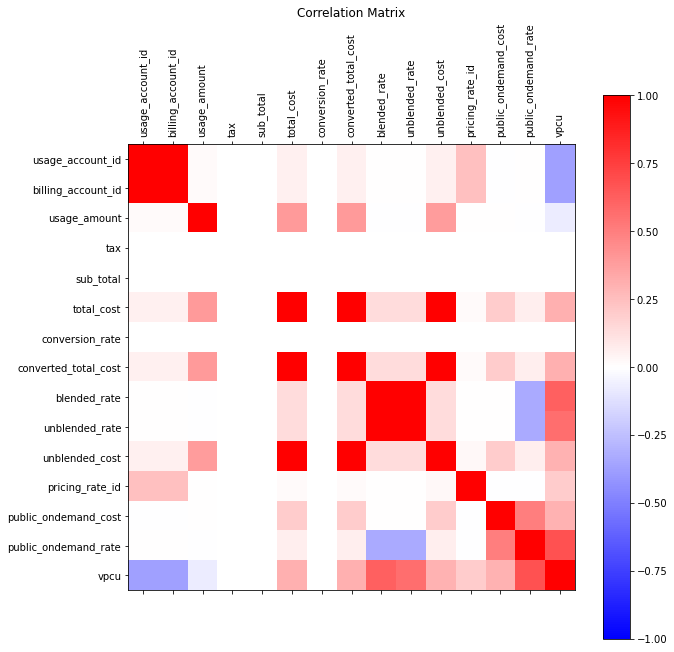

In [13]:
plot_corr(dfTotal)

It looks like there's some light correlation to usage and the vcpu count... nothing too useful, although we may need to make another correlation matrix after some data augmentation. Next, let's look at the %NaN for each column to see which columns are generally unused in the dataset.

In [14]:
dfTotal.isna().sum() / dfTotal.shape[0]

cloud_resource_id       0.003146
usage_account_id        0.000000
billing_account_id      0.000000
provider_code           0.000000
usage_amount            0.000000
currency_code           0.000000
tax                     0.000000
sub_total               0.000000
total_cost              0.000000
system_currency_code    0.000000
conversion_rate         0.000000
converted_total_cost    0.000000
product_name            0.000000
service_code            0.084868
service_name            0.084906
product_sku             0.000605
availability_zone       0.995690
location_id             0.000605
usage_type              0.084868
usage_type_group        0.989718
cost_type               0.000000
instance_type           0.996030
blended_rate            0.000000
unblended_rate          0.000000
unblended_cost          0.000000
category                0.000000
clock_speed             0.996988
from_location           0.577076
to_location             0.577076
transfer_type           0.577076
pricing_ra

It looks like the 3 columns for transfers all need one another to exist. Then, the columns like "instance_type", "volume_type", and "operating_system" all likely point towards the amount of line items that are actual VMs that have been spun up rather than associated costs or abstracted cloud services. It could perhaps be possible to use the amount of rows we have for each of those columns as advisors of fixed costs as certain server instances such as domain controllers, FTP servers, and application servers require high availability.

In [15]:
dfPYCO.sort_values("total_cost", ascending=False)[["invoice_month", "product_name", "total_cost"]]

,invoice_month,product_name,total_cost
65279,2019-09-01,Amazon Elastic Compute Cloud,3284.000000
28934,2019-09-01,AWS Support (Business),1000.000000
96649,2019-10-01,AWS Support (Business),1000.000000
114403,2019-10-01,Amazon Elastic File System,879.020880
29088,2019-09-01,Amazon Elastic File System,861.036975
...,...,...,...
567528,2019-12-01,Amazon Elastic Compute Cloud,-3.050000
96842,2019-10-01,Amazon Elastic Compute Cloud,-100.000000
28932,2019-09-01,AWS Support (Business),-130.774159
96648,2019-10-01,AWS Support (Business),-708.380000


Here, we see some interesting behaviour where it looks like there were certain charges put forward that then had to be fixed (look at the indices of the largest negative charges and how they're +1 of the large charges).

____
## Plotting
Now, let's make some figures to get an idea of how the big hitter services are affecting costs month over month.

In [8]:
def hitter_monthly(df, product):
    """
    Grabs the total cost incurred by the big hitter (product) for each month of the DataFrame, df
    """
    dfFin = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum"})
    return dfFin

In [9]:
def plot_n_hitters(n_hitters):
    """
    Plots the N biggest overall hitters and the aggregate cost
    """
    top_hitters = dfTotal.groupby("product_name").agg({"total_cost": "sum"}).sort_values("total_cost", ascending=False).index[:n_hitters]
    company_dfs = [dfXCO, dfPYCO, dfCCO]
    company_names = ["XCO", "PYCO", "CCO"]
    final_df_list = []
    fig, ax = plt.subplots(3,2, figsize=(30,20))
    for index in range(len(company_names)):
        inter_list = []

        for hitter in range(len(top_hitters)):
            new_monthly_df = hitter_monthly(company_dfs[index], top_hitters[hitter])
            ax[index][0].plot(new_monthly_df)
            ax[index][0].tick_params("x", rotation=90)
            inter_list.append(new_monthly_df)


        ax[index][0].set_title(str(company_names[index]) + " big hitters monthly cost")
        ax[index][0].legend(top_hitters)
        final_df_list.append(inter_list)
        agg_df = company_dfs[index].groupby("invoice_month").agg({"total_cost": "sum"})
        ax[index][1].plot(agg_df, color="red")
        ax[index][1].set_title(str(company_names[index]) + " total monthly cost")
        ax[index][1].tick_params("x", rotation=90)

    fig.tight_layout()    
    fig.savefig(r".\figures\graphs_mod" + str(n_hitters) + ".png")
    return final_df_list

In [10]:
def plot_n_hitters_bycorp(n_hitters):
    """
    Plots the top N big hitters on a company-by-company basis (possibly different for each company)
    """
    company_dfs = [dfXCO, dfPYCO, dfCCO]
    company_names = ["XCO", "PYCO", "CCO"]
    final_df_list = []
    fig, ax = plt.subplots(3,2, figsize=(30,20))
    for index in range(len(company_names)):
        inter_list = []
        top_hitters = company_dfs[index].groupby("product_name").agg({"total_cost": "sum"}).sort_values("total_cost", ascending=False).index[:n_hitters]
        
        for hitter in range(len(top_hitters)):
            new_monthly_df = hitter_monthly(company_dfs[index], top_hitters[hitter])
            ax[index][0].plot(new_monthly_df)
            ax[index][0].tick_params("x", rotation=90)
            inter_list.append(new_monthly_df)


        ax[index][0].set_title(str(company_names[index]) + " big hitters monthly cost")
        ax[index][0].legend(top_hitters)
        final_df_list.append(inter_list)
        agg_df = company_dfs[index].groupby("invoice_month").agg({"total_cost": "sum"})
        ax[index][1].plot(agg_df, color="red")
        ax[index][1].set_title(str(company_names[index]) + " total monthly cost")
        ax[index][1].tick_params("x", rotation=90)

    fig.tight_layout()    
    fig.savefig(r".\figures\company_hitters_" + str(n_hitters) + ".png")

____
The first plot here is a demonstration of how the top 5 overall "big hitters" affect the aggregate cost (right) for each company. We can see that the top 5 big hitters aren't necessarily the biggest cost drivers for each company. Another interesting insight is how for XCO, the graphical shape seems to be driven more by Amazon DocumentDB even though it's not the largest charge most months, it is the biggest contributor of variance.
____

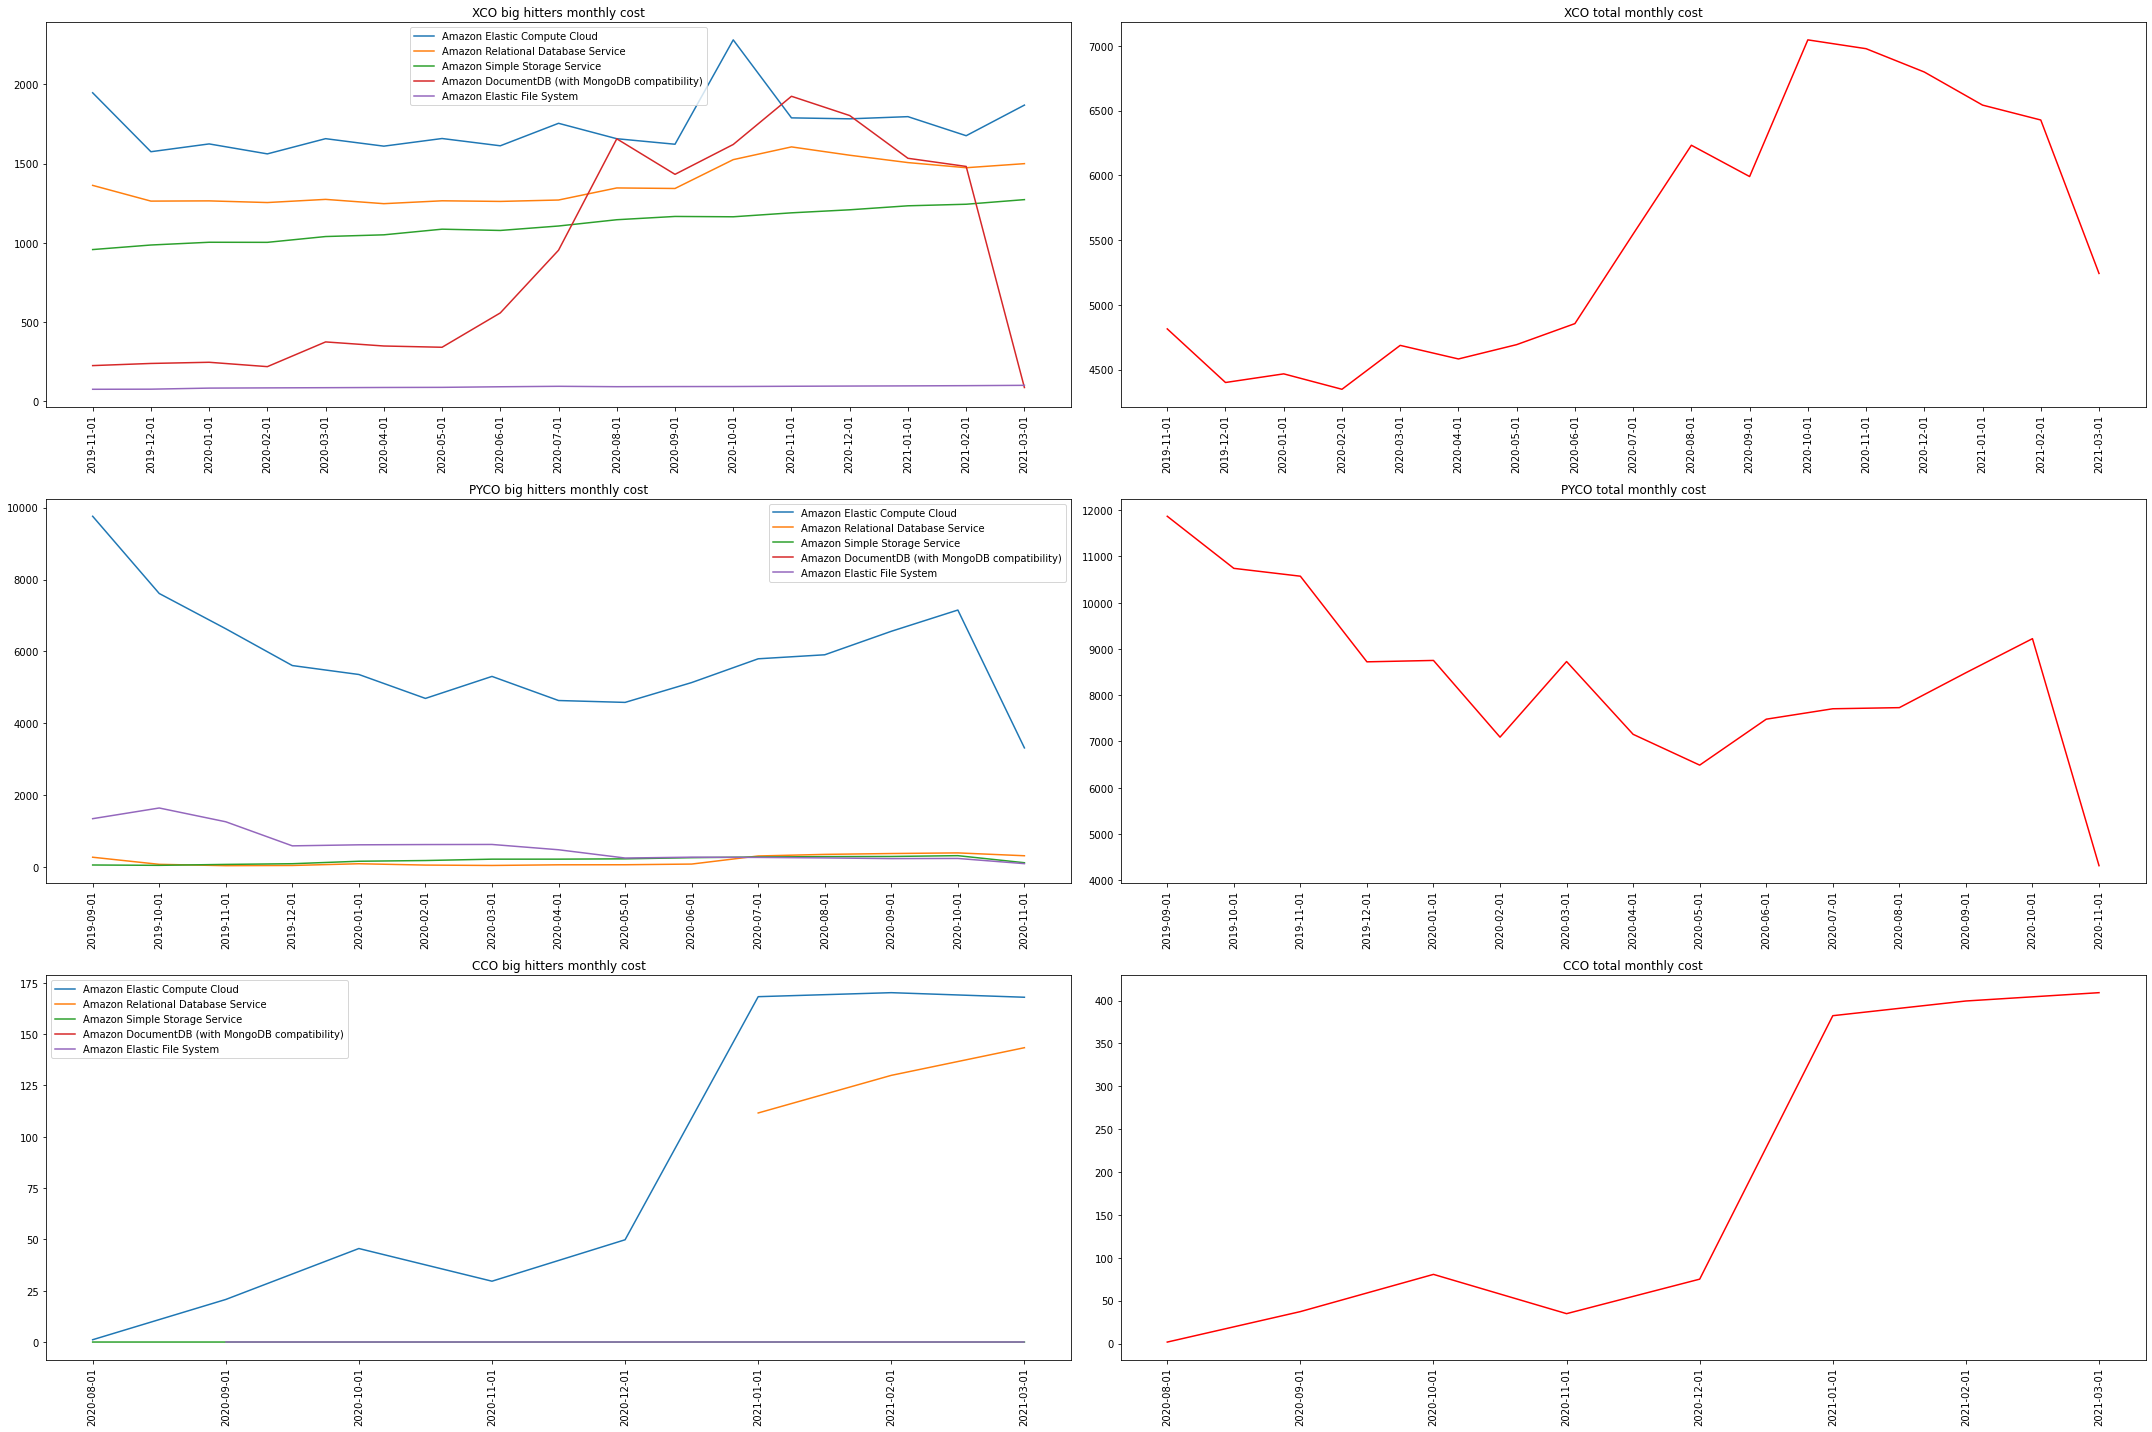

In [16]:
top_5 = plot_n_hitters(5)

____
Here, we look at the top 5 top "big hitters" and see that there were a lot of costs that matter to company with a smaller cloud footprint, like CCO that don't necessarily affect a relatively larger corporation like PYCO.
____

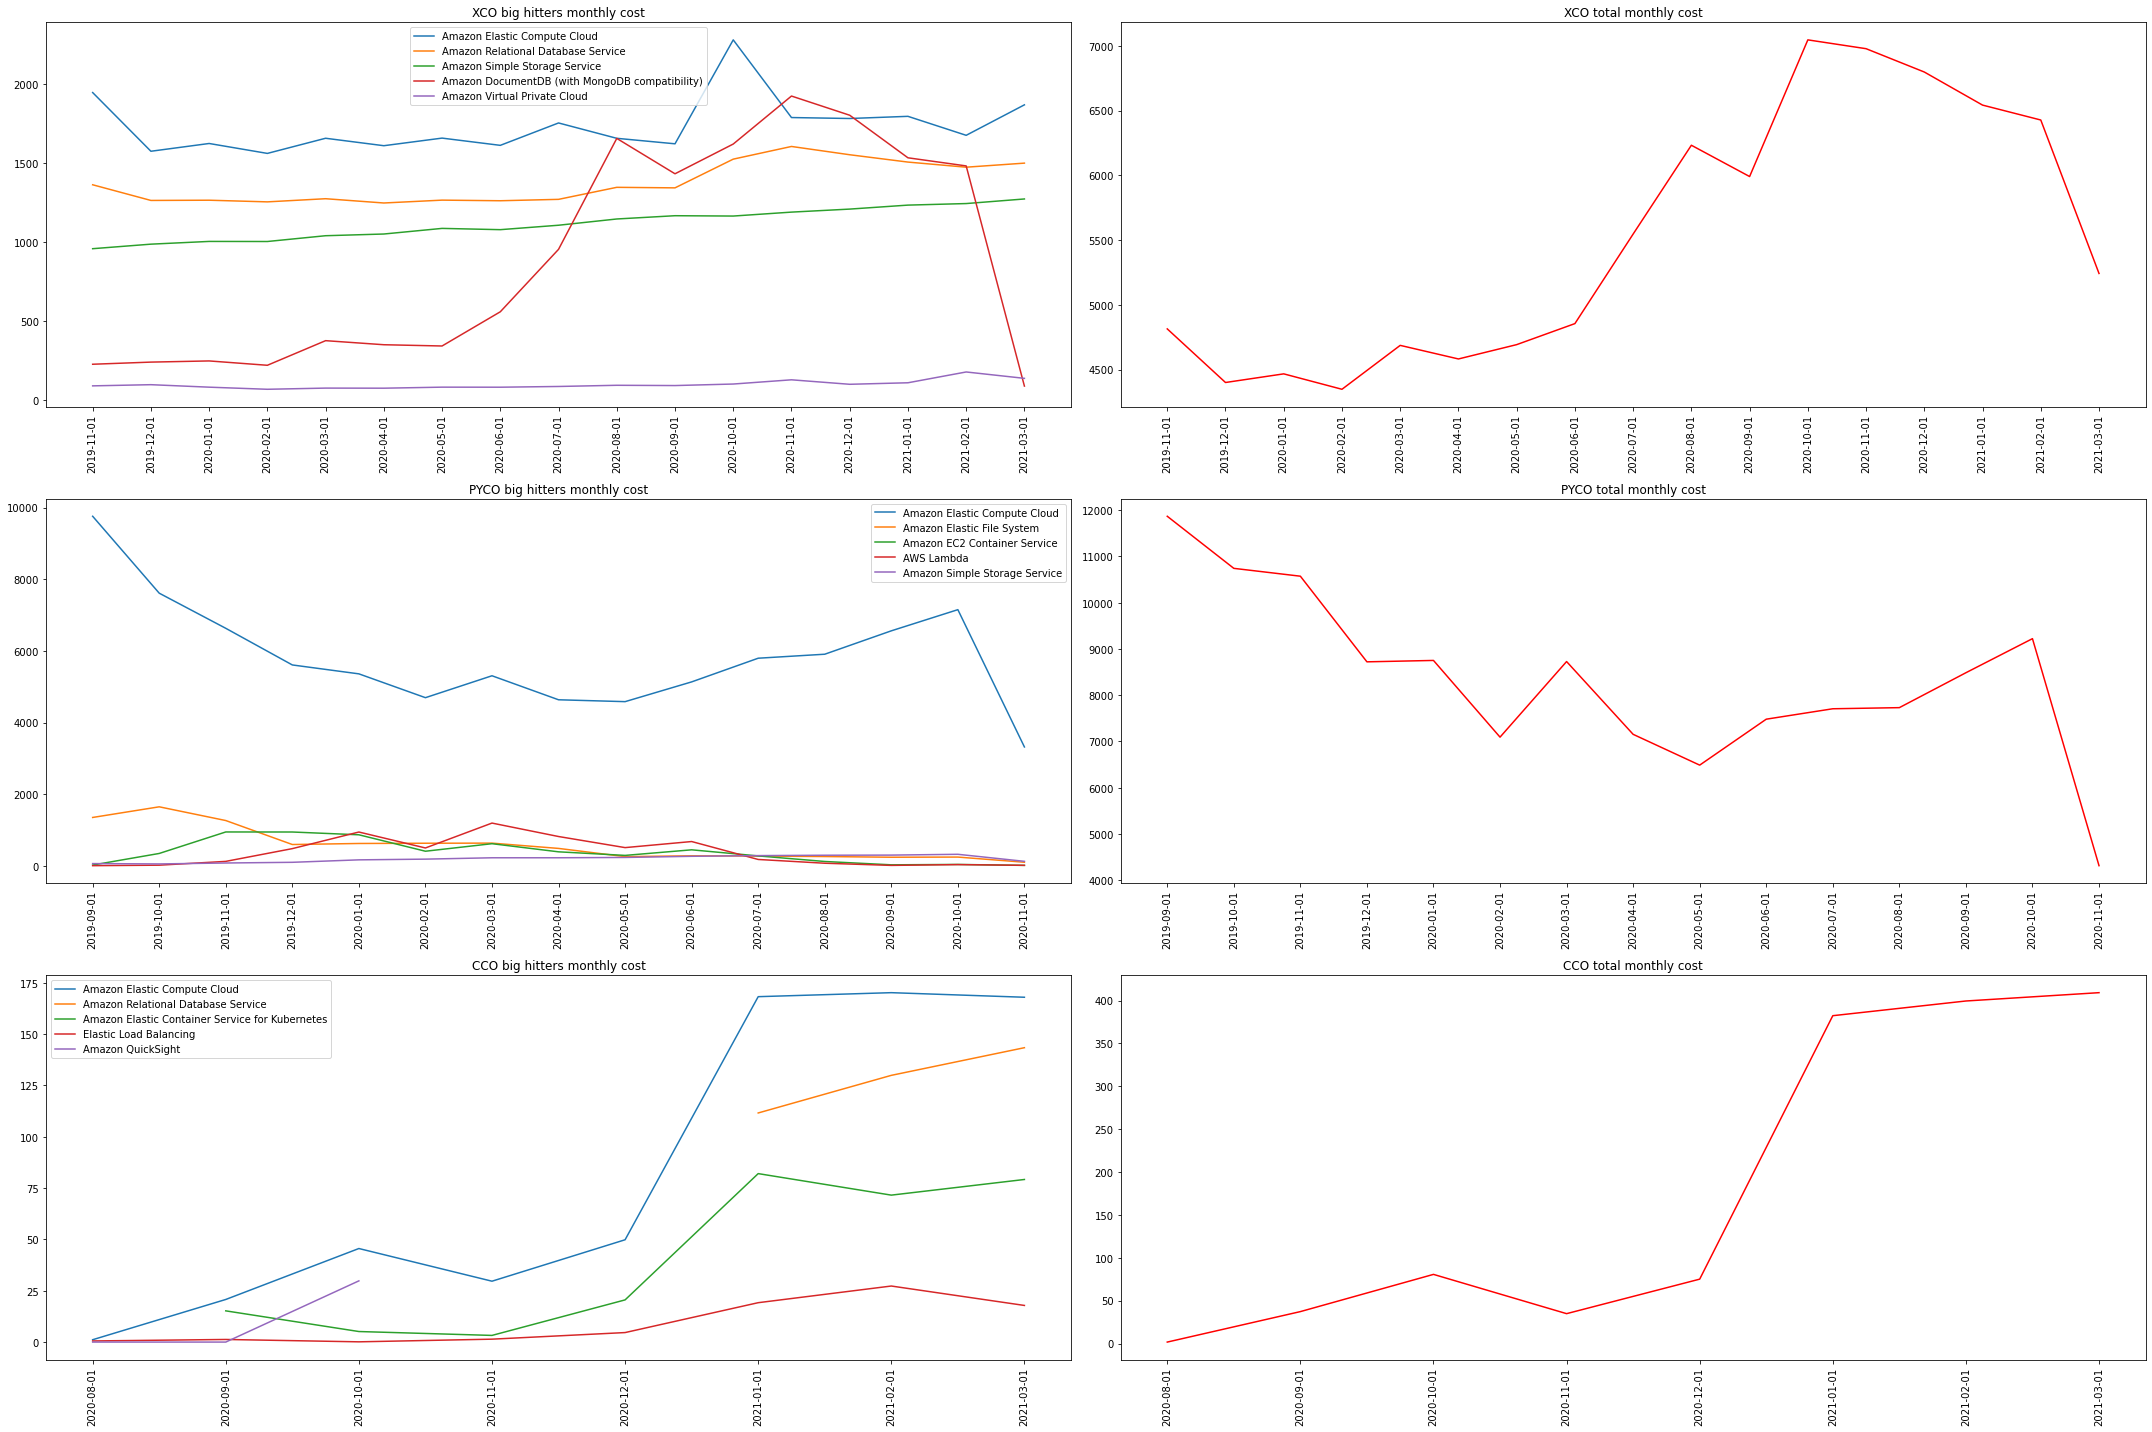

In [17]:
plot_n_hitters_bycorp(5)

## Data Processing

In [18]:
# First start the creation of our final dataframe, starting with total monthly cost
def process_dataframe(df, fillna=True):
    """
    Processes a dataFrame from what's initially given to a usable form for our model.
    """
    dfProcessed = df.groupby("invoice_month").agg({"total_cost": "sum"})
    products = dfTotal["product_name"].unique()
    # Loops through all of the unique product names
    for product in products:
        # Grabs the monthly total cost and usage for each product
        df_product_monthly = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum", "usage_amount": "sum"}).rename(columns={"total_cost" : product + " cost", "usage_amount": product + " usage"})
        #Concatenates that onto the total dataframe we have
        dfProcessed = pd.concat([dfProcessed, df_product_monthly], axis=1)
    if fillna==True:    
        dfProcessed = dfProcessed.fillna(0)
    return dfProcessed

In [19]:
dfCCO_processed = process_dataframe(dfCCO, fillna=False)
dfCCO_processed

,total_cost,Elastic Load Balancing cost,Elastic Load Balancing usage,Amazon Elastic Compute Cloud cost,Amazon Elastic Compute Cloud usage,Amazon Simple Storage Service cost,Amazon Simple Storage Service usage,AWS Key Management Service cost,AWS Key Management Service usage,Amazon Cognito cost,Amazon Cognito usage,AmazonCloudWatch cost,AmazonCloudWatch usage,Amazon EC2 Container Service cost,Amazon EC2 Container Service usage,Amazon QuickSight cost,Amazon QuickSight usage,Amazon Simple Queue Service cost,Amazon Simple Queue Service usage,Amazon Elastic Container Service for Kubernetes cost,Amazon Elastic Container Service for Kubernetes usage,AWS Data Transfer cost,AWS Data Transfer usage,AWS Lambda cost,AWS Lambda usage,Amazon Elastic File System cost,Amazon Elastic File System usage,Amazon Simple Notification Service cost,Amazon Simple Notification Service usage,AWS Config cost,AWS Config usage,Amazon Relational Database Service cost,Amazon Relational Database Service usage,AWS Glue cost,AWS Glue usage,AWS Secrets Manager cost,AWS Secrets Manager usage,Amazon Athena cost,Amazon Athena usage,Amazon ElastiCache cost,Amazon ElastiCache usage,Amazon Simple Email Service cost,Amazon Simple Email Service usage,Amazon EC2 Container Registry (ECR) cost,Amazon EC2 Container Registry (ECR) usage,AWS Support (Developer) cost,AWS Support (Developer) usage,AWS Data Pipeline cost,AWS Data Pipeline usage,Amazon Route 53 cost,Amazon Route 53 usage,Cyber Security Cloud Managed Rules for AWS WAF -API Gateway/Serverless- cost,Cyber Security Cloud Managed Rules for AWS WAF -API Gateway/Serverless- usage,AWS CloudTrail cost,AWS CloudTrail usage,Amazon CloudFront cost,Amazon CloudFront usage,AWS WAF cost,AWS WAF usage,Amazon API Gateway cost,Amazon API Gateway usage,AWS Cost Explorer cost,AWS Cost Explorer usage,Amazon DynamoDB cost,Amazon DynamoDB usage,AWS Support (Business) cost,AWS Support (Business) usage,Amazon Kinesis Firehose cost,Amazon Kinesis Firehose usage,AWS Elemental MediaStore cost,AWS Elemental MediaStore usage,AWS Systems Manager cost,AWS Systems Manager usage,Amazon Elasticsearch Service cost,Amazon Elasticsearch Service usage,AWS X-Ray cost,AWS X-Ray usage,AWS Database Migration Service cost,AWS Database Migration Service usage,Amazon SageMaker cost,Amazon SageMaker usage,CloudEndure Disaster Recovery to AWS cost,CloudEndure Disaster Recovery to AWS usage,Amazon Lightsail cost,Amazon Lightsail usage,Amazon DocumentDB (with MongoDB compatibility) cost,Amazon DocumentDB (with MongoDB compatibility) usage,Amazon Virtual Private Cloud cost,Amazon Virtual Private Cloud usage,AWS Step Functions cost,AWS Step Functions usage,Amazon Registrar cost,Amazon Registrar usage,Amazon Glacier cost,Amazon Glacier usage
invoice_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1.717943,0.547634,24.021073,1.147767,24.566741,0.022542,543.011748,0.0,18.0,0.0,2.0,0.00000,0.058898,0.0,6.935227,0.000000,3.930108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,37.258579,1.273340,54.133633,20.755028,824.133404,0.021228,2575.908828,0.0,20.0,0.0,1.0,0.00006,6.141876,0.0,9.292604,0.000000,3.955556,NaN,NaN,15.208816,143.688158,0.00,1.0,NaN,NaN,0.000106,0.000352,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,80.664613,0.122506,6.000797,45.572186,1189.248625,0.013111,761.534243,0.0,9.0,NaN,NaN,0.00000,6.725843,NaN,NaN,29.817742,4.107527,0.0,6.0,5.138936,49.189360,0.00,1.0,0.000000,4.3125

### CCO 

Interesting things to note:

* The only negative correlations lie with the Amazon Elastic File System

* Cost variance seems to be driven strongly by many different services. Likely points to a ramping up of cloud costs, which was reflected in our earlier plots

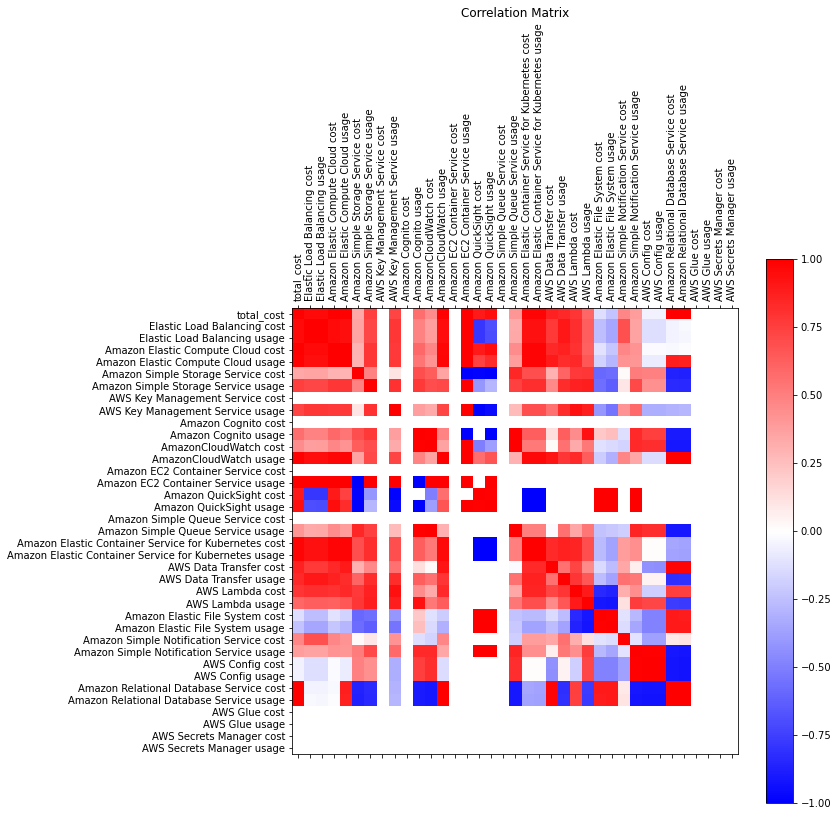

In [20]:
# CCO Correlation Matrix
plot_corr(dfCCO_processed.dropna(axis=1, how="all"))

### PYCO

Interesting things to note:  

* There's a somewhat large amount of negative correlations for cost, but none are very strong.

* The strongest correlation seems to lie with Amazon Elastic File System costs

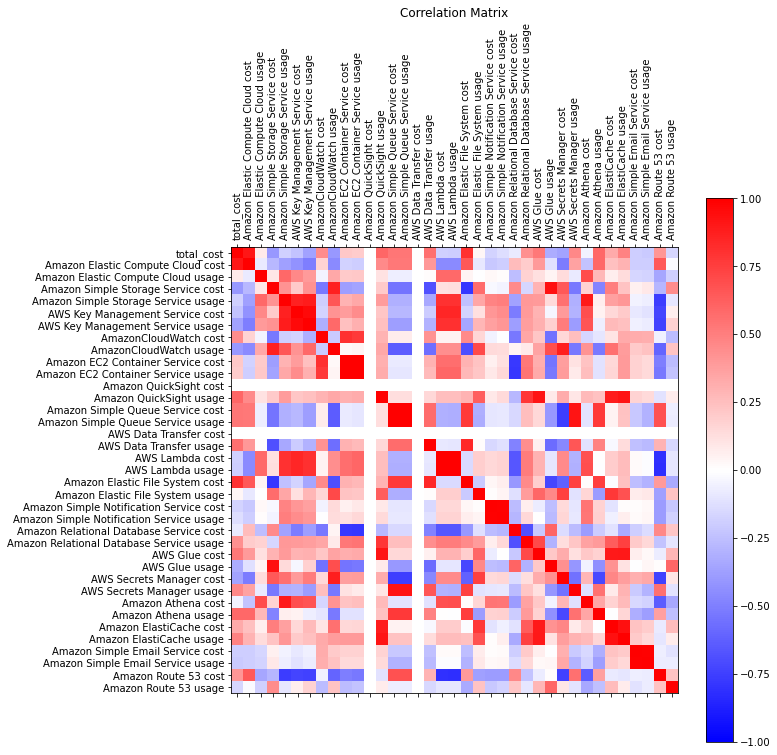

In [21]:
dfPYCO_processed = process_dataframe(dfPYCO, fillna=False)
# PYCO Correlation Matrix
plot_corr(dfPYCO_processed.dropna(axis=1))

### XCO
Interesting points to note:  

* Amazon Lightsail cost has a fairly strong negative correlation with total cost.  

* Amazon Relational DB Cost, Amazon simple storage, and Amazon DocumentDB are cost variance drivers. This seems to be a company that intakes a good amount of data and the data intake seems to correlate with increasing costs.

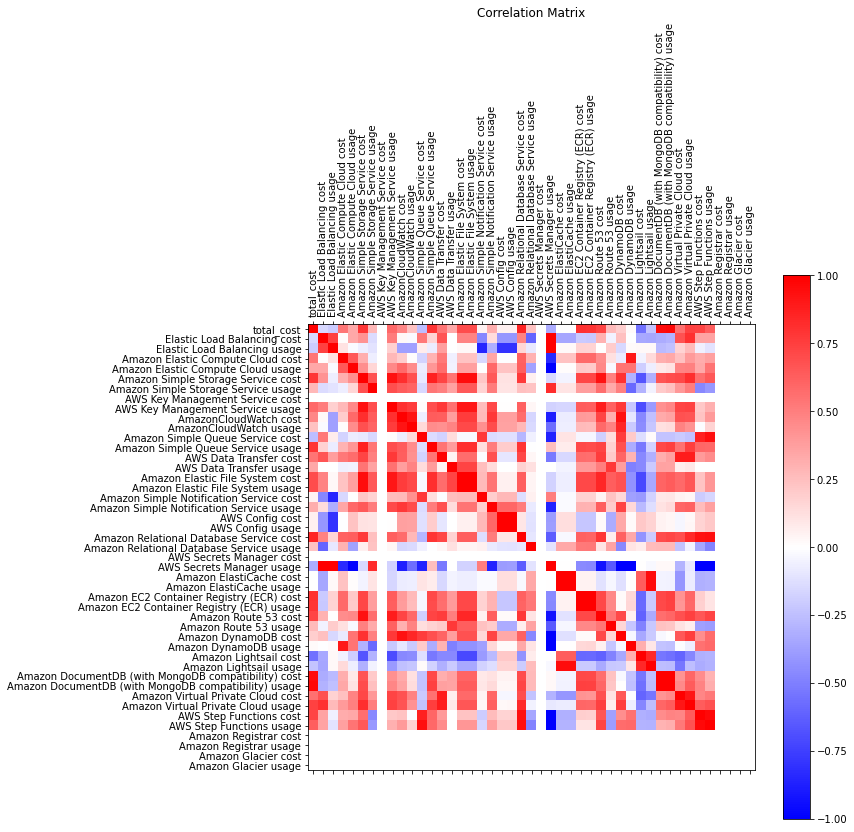

In [22]:
dfXCO_processed = process_dataframe(dfXCO, fillna=False)
plot_corr(dfXCO_processed.dropna(axis=1, how="all"))

# Expected Objective/Modelling

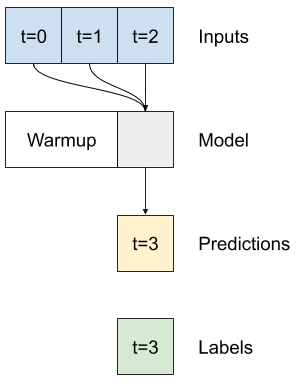